## Inverse Cooking: Recipe Generation from Food Images

In [1]:
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import numpy as np
import os
from args import get_parser
import pickle
from model import get_model
from torchvision import transforms
from utils.output_utils import prepare_output
from PIL import Image
import time

Set ```data_dir``` to the path including vocabularies and model checkpoint

In [2]:
data_dir = '../data'

In [3]:
# code will run in gpu if available and if the flag is set to True, else it will run on cpu
use_gpu = False
device = torch.device('cuda' if torch.cuda.is_available() and use_gpu else 'cpu')
map_loc = None if torch.cuda.is_available() and use_gpu else 'cpu'

In [4]:
# code below was used to save vocab files so that they can be loaded without Vocabulary class
#ingrs_vocab = pickle.load(open(os.path.join(data_dir, 'final_recipe1m_vocab_ingrs.pkl'), 'rb'))
#ingrs_vocab = [min(w, key=len) if not isinstance(w, str) else w for w in ingrs_vocab.idx2word.values()]
#vocab = pickle.load(open(os.path.join(data_dir, 'final_recipe1m_vocab_toks.pkl'), 'rb')).idx2word
#pickle.dump(ingrs_vocab, open('../demo/ingr_vocab.pkl', 'wb'))
#pickle.dump(vocab, open('../demo/instr_vocab.pkl', 'wb'))

ingrs_vocab = pickle.load(open(os.path.join(data_dir, 'ingr_vocab.pkl'), 'rb'))
vocab = pickle.load(open(os.path.join(data_dir, 'instr_vocab.pkl'), 'rb'))

ingr_vocab_size = len(ingrs_vocab)
instrs_vocab_size = len(vocab)
output_dim = instrs_vocab_size

In [5]:
print (instrs_vocab_size, ingr_vocab_size)

23231 1488


In [6]:
t = time.time()
import sys; sys.argv=['']; del sys
args = get_parser()
args.maxseqlen = 15
args.ingrs_only=False
model = get_model(args, ingr_vocab_size, instrs_vocab_size)
# Load the trained model parameters
model_path = os.path.join(data_dir, 'modelbest.ckpt')
model.load_state_dict(torch.load(model_path, map_location=map_loc))
model.to(device)
model.eval()
model.ingrs_only = False
model.recipe_only = False
print ('loaded model')
print ("Elapsed time:", time.time() -t)


Downloading: "https://download.pytorch.org/models/resnet50-19c8e357.pth" to /home/ivan/.cache/torch/hub/checkpoints/resnet50-19c8e357.pth


  0%|          | 0.00/97.8M [00:00<?, ?B/s]

/home/ivan/anaconda3/envs/icook/lib/python3.7/site-packages/torch/nn/_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))


loaded model
Elapsed time: 130.23824405670166


In [7]:
transf_list_batch = []
transf_list_batch.append(transforms.ToTensor())
transf_list_batch.append(transforms.Normalize((0.485, 0.456, 0.406), 
                                              (0.229, 0.224, 0.225)))
to_input_transf = transforms.Compose(transf_list_batch)

In [8]:
greedy = [True, False, False, False]
beam = [-1, -1, -1, -1]
temperature = 1.0
numgens = len(greedy)

Set ```use_urls = True``` to get recipes for images in ```demo_urls```. 

You can also set ```use_urls = False``` and get recipes for images in the path in ```data_dir/test_imgs```.

In [9]:
import requests
from io import BytesIO
import random
from collections import Counter
use_urls = False # set to true to load images from demo_urls instead of those in test_imgs folder
show_anyways = False #if True, it will show the recipe even if it's not valid
image_folder = os.path.join(data_dir, 'demo_imgs')

if not use_urls:
    demo_imgs = os.listdir(image_folder)
    random.shuffle(demo_imgs)

demo_urls = ['https://food.fnr.sndimg.com/content/dam/images/food/fullset/2013/12/9/0/FNK_Cheesecake_s4x3.jpg.rend.hgtvcom.826.620.suffix/1387411272847.jpeg',
            'https://www.196flavors.com/wp-content/uploads/2014/10/california-roll-3-FP.jpg']

demo_files = demo_urls if use_urls else demo_imgs

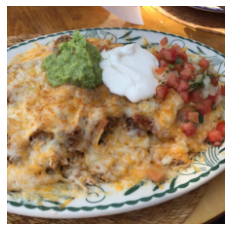

RECIPE 1

Title: Chicken enchiladas

Ingredients:
cheese, tortilla, onion, cream, enchilada_sauce, chicken, chili, beans, pepper, tomato, cumin

Instructions:
-Preheat oven to 350 degrees.
-In a large bowl, combine chicken, beans, tomatoes, onion, green chilies, cumin, and chili powder.
-Spoon about 1/4 cup of the chicken mixture down the center of each tortilla.
-Roll up and place seam side down in a greased 13x9 baking dish.
-Pour enchilada sauce over enchiladas.
-Sprinkle with cheese.
-Bake uncovered for 20 minutes.
RECIPE 2

Title: Enchilada pie

Ingredients:
cheese, tortilla, onion, cream, enchilada_sauce, chicken, chili, beans, pepper, tomato, cumin

Instructions:
-Heat oven to 350f.
-Spray 13'' x 9'' glass baking dish with non-stick cooking spray.
-Combine chicken, enchilada sauce, onion, black beans, tomatoes, cumin, chili powder and cayenne.
-Place tortillas on bottom of prepared dish, overlapping slightly.
-Spoon mixture over tortillas and top with cheese.
-Bake 30 minutes.
-

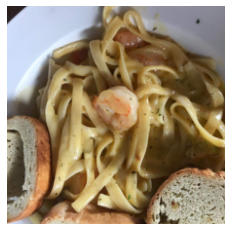

RECIPE 1

Title: Garlic shrimp scampi

Ingredients:
shrimp, pepper, butter, clove, oil, salt, pasta, parsley

Instructions:
-Heat olive oil in a large skillet over medium heat.
-Cook and stir garlic in hot oil until fragrant, about 1 minute.
-Stir shrimp into garlic; cook and stir until shrimp are pink and opaque, about 3 minutes.
-Season with salt and pepper.
-Stir butter into shrimp mixture until melted and sauce is heated through, about 2 minutes.
-Stir parsley into shrimp mixture; cook and stir until heated through, about 1 minute.
RECIPE 2

Title: Garlic shrimp

Ingredients:
shrimp, pepper, butter, clove, oil, salt, pasta, parsley

Instructions:
-Bring a large pot of heavily salted water to a boil.
-Add the pasta and cook until it is al dente, about 8 minutes.
-Drain, reserving 1 cup of the cooking water.
-Return the pasta to the pot.
-Meanwhile, in a medium saucepan, heat the vegetable oil over medium heat.
-Add the garlic, parsley, salt and pepper and cook until fragrant, about 

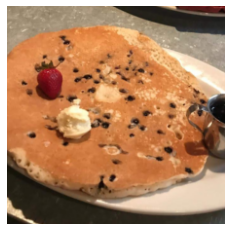

RECIPE 1

Title: Easy pancakes

Ingredients:
sugar, flour, egg, salt, butter, baking_powder, milk, oil

Instructions:
-Mix all ingredients together.
-Heat skillet and pour 1/4 cup of batter onto skillet.
-Cook until bubbles form on top.
-Flip and cook until golden brown.
Not a valid recipe!
Reason:  no eos found
RECIPE 2

Title: Peanut butter pancakes

Ingredients:
sugar, flour, egg, salt, butter, baking_powder, milk, oil

Instructions:
-Sift together flour, milk, baking powder, and salt in a large mixing bowl.
-Mix the eggs, sugar, peanut butter, and vegetable oil together in a small bowl, then add the egg-milk mixture and stir just to combine.
-Heat a lightly oiled griddle or skillet over medium heat.
-Pour or scoop the batter onto the griddle, making pancakes about 2 to 3 1/2 inches apart.
-Cook until bubbles form and the edges are dry and the edges are golden, 2 to 3 minutes.
-Turn the pancakes and cook until golden brown on the other side, 2 to 3 minutes.
-Transfer to a plate and 

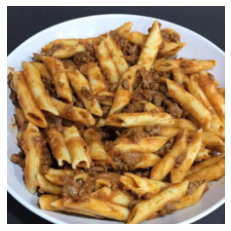

RECIPE 1

Title: Penne with caramelized onions

Ingredients:
cheese, pasta, pepper, onion, oil

Instructions:
-Heat oil in large skillet over medium-high heat.
-Add onions; cook until golden brown, stirring occasionally, about 15 minutes.
-Add pasta and cook until heated through, stirring occasionally, about 10 minutes.
-Season with salt and pepper.
-Sprinkle with cheese.
RECIPE 2

Title: Ziti

Ingredients:
cheese, pasta, pepper, onion, oil

Instructions:
-Cook pasta according to package directions.
-Meanwhile, saute onions in olive oil until clear.
-Add cooked ziti and sauce.
-Stir in ricotta cheese, mozzarella and parmesan.
-Season with salt and pepper to taste.
-Cook for about 10 minutes, stirring occasionally until cheese is melted and ziti is hot.
RECIPE 3

Title: Ziti with caramelized onions, parmesan and black pepper

Ingredients:
cheese, pasta, pepper, onion, oil

Instructions:
-Preheat oven to 450 degrees f.
-Bring a large pot of lightly salted water to a boil.
-Add pasta and 

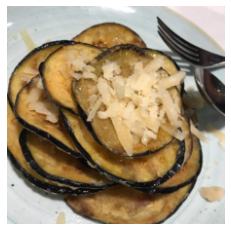

RECIPE 1

Title: Grilled eggplant and zucchini

Ingredients:
zucchini, oil, salt, squash, pepper, eggplant

Instructions:
-Preheat grill to medium-high.
-Brush eggplant slices with oil and season with salt and pepper.
-Grill, turning once, until tender and lightly charred, about 10 minutes.
-Transfer to a platter and let cool.
-Cut into 1/2-inch slices.
-Serve with grilled zucchini.
RECIPE 2

Title: Sauteed eggplant with eggplant and zucchini

Ingredients:
zucchini, oil, salt, squash, pepper, eggplant

Instructions:
-Heat 1 teaspoon of the oil in a 12-inch nonstick skillet over moderately high heat until hot but not smoking, then cook the eggplant, stirring occasionally, until lightly browned but not cooked, 6 to 8 minutes total.
-Add the squash, season with salt, and pepper, then saute until the eggplant is tender, about 3 minutes longer.
-Serve with hot buttered polenta.
RECIPE 3

Title: Grilled zucchini with summer squash

Ingredients:
zucchini, oil, salt, squash, pepper, eggplant



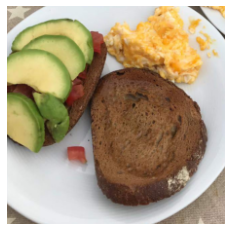

RECIPE 1

Title: Avocado egg salad sandwich

Ingredients:
avocado, bread, tomato, mayonnaise, pepper, egg, salt

Instructions:
-Toast bread.
-Spread mayonnaise on one side of each slice.
-Place avocado slices on one slice of bread.
-Top with tomato slices and salt and pepper.
-Top with other slice of bread.
RECIPE 2

Title: Avocado egg sandwich

Ingredients:
avocado, bread, tomato, mayonnaise, pepper, egg, salt

Instructions:
-Mash avocado and salt together, add mayonnaise and mix well.
-Toast bread.
-Spread mixture on one side of one piece of bread.
-Top with other piece of bread.
-Cut in half and enjoy !
RECIPE 3

Title: Eggs with tomatoes and avocado (low fat)

Ingredients:
avocado, bread, tomato, mayonnaise, pepper, egg, salt

Instructions:
-Preheat an oven to 450 degrees f (230 degrees c).
-Line a baking sheet with parchment paper.
-Place the bread on the prepared baking sheet.
-Bake in the preheated oven until golden, about 5 minutes.
-Place the eggs in a large bowl; beat with an

In [10]:
for img_file in demo_files:
    
    if use_urls:
        response = requests.get(img_file)
        image = Image.open(BytesIO(response.content))
    else:
        image_path = os.path.join(image_folder, img_file)
        image = Image.open(image_path).convert('RGB')
    
    transf_list = []
    transf_list.append(transforms.Resize(256))
    transf_list.append(transforms.CenterCrop(224))
    transform = transforms.Compose(transf_list)
    
    image_transf = transform(image)
    image_tensor = to_input_transf(image_transf).unsqueeze(0).to(device)
    
    plt.imshow(image_transf)
    plt.axis('off')
    plt.show()
    plt.close()
    
    num_valid = 1
    for i in range(numgens):
        with torch.no_grad():
            outputs = model.sample(image_tensor, greedy=greedy[i], 
                                   temperature=temperature, beam=beam[i], true_ingrs=None)
            
        ingr_ids = outputs['ingr_ids'].cpu().numpy()
        recipe_ids = outputs['recipe_ids'].cpu().numpy()
            
        outs, valid = prepare_output(recipe_ids[0], ingr_ids[0], ingrs_vocab, vocab)
        
        if valid['is_valid'] or show_anyways:
            
            print ('RECIPE', num_valid)
            num_valid+=1
            #print ("greedy:", greedy[i], "beam:", beam[i])
    
            BOLD = '\033[1m'
            END = '\033[0m'
            print (BOLD + '\nTitle:' + END,outs['title'])

            print (BOLD + '\nIngredients:'+ END)
            print (', '.join(outs['ingrs']))

            print (BOLD + '\nInstructions:'+END)
            print ('-'+'\n-'.join(outs['recipe']))

            print ('='*20)

        else:
            pass
            print ("Not a valid recipe!")
            print ("Reason: ", valid['reason'])
        